# CLUSTERING- FINDING BEST DEAL WITH FLIGHTS 

### Dataset oveview

Dataset we used to build this model is scrapped from Kayak website using beautiful soup python library. This dataset mainly contains data about the flights which are available from certain sources to destinations between January 2024 to April 2024. Using the important features like Airline, Source, Destination, Duraion, Departure time, Arrival time, Total stops, Layover city,Layover time, Checkin and cabin bags , Price. we are trying to find the best deal to book a flight.

The collected data saved as CSV files is embedded into one master data file which is available in the below link.
https://raw.githubusercontent.com/priyankaa-k/Kayak_flight_data_clustering/main/Master_Data.csv

Data scrapped from https://www.ca.kayak.com/flights

### Importing  libraries

In [1]:
import pandas as pd
import numpy as np
import pytz
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
%matplotlib inline
from sklearn.preprocessing import MultiLabelBinarizer

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")


STEP1: Data collection has been done by web scrapping the KAYAK website, Code used to scarp data is available in our other ipynb file which is Scarapping.ipynb

### Data Wrangling

Step 2: All the Data wrangling has done in below cells

In [2]:
#IMPORTING THE csv FILE AS DATAFRAME
df = pd.read_csv(r'https://raw.githubusercontent.com/priyankaa-k/Kayak_flight_data_clustering/main/Master_Data.csv',index_col='Unnamed: 0')

In [3]:
#printing the DF
df.head()

,Date,Airline,Duration,Source,Destination,Departure Time,Arrival Time,Layover Time,Layover Cities,Total stops,Carry bags Count,Checkin bags Count,Price
0,01/03/2024,Lufthansa,10h 30m,Los Angeles,London,7:00 pm,1:30 pm,NaN,NaN,0.0,1.0,0.0,507
1,01/03/2024,WestJet,21h 30m,Los Angeles,London,7:00 am,12:30 pm,9h 41m,Calgary,1.0,1.0,0.0,393
2,01/03/2024,United Airlines,10h 30m,Los Angeles,London,7:00 pm,1:30 pm,NaN,NaN,0.0,1.0,0.0,558
3,01/03/2024,Austrian Airlines,10h 30m,Los Angeles,London,7:00 pm,1:30 pm,NaN,NaN,0.0,1.0,1.0,758
4,01/03/2024,Brussels Airlines,10h 30m,Los Angeles,London,7:00 pm,1:30 pm,NaN,NaN,0.0,1.0,1.0,758


In [4]:
#shape shows the amount of rows and columns
df.shape

(70349, 13)

In [5]:
#to show the distributions of continuous columns
df.describe()

,Total stops,Carry bags Count,Checkin bags Count
count,70349.000000,69823.000000,70323.000000
mean,1.313437,0.962204,0.581062
std,0.597429,0.190703,0.732800
min,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000
50%,1.000000,1.000000,0.000000
75%,2.000000,1.000000,1.000000
max,4.000000,1.000000,2.000000


In [6]:
#info shows the Dtype,count of nonnull values of df
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70349 entries, 0 to 94196
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                70349 non-null  object 
 1   Airline             70349 non-null  object 
 2   Duration            70349 non-null  object 
 3   Source              70349 non-null  object 
 4   Destination         70349 non-null  object 
 5   Departure Time      70349 non-null  object 
 6   Arrival Time        70349 non-null  object 
 7   Layover Time        66413 non-null  object 
 8   Layover Cities      66413 non-null  object 
 9   Total stops         70349 non-null  float64
 10  Carry bags Count    69823 non-null  float64
 11  Checkin bags Count  70323 non-null  float64
 12  Price               70349 non-null  object 
dtypes: float64(3), object(10)
memory usage: 7.5+ MB


Since the data types of certain features are not in proper way like  price feature as object instead of numeric and Date is also object but it should be datatime etc that was handled below

In [7]:
#caling function to change data type of columns
def change_datatype(df):
    #changing the data type for below columns
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', errors='coerce')
    df['Departure Time'] = pd.to_datetime(df['Departure Time'], format='%I:%M %p').dt.strftime('%H:%M:%S')
    df['Arrival Time'] = pd.to_datetime(df['Arrival Time'], format='%I:%M %p').dt.strftime('%H:%M:%S')   
    df['Price'] = df['Price'].str.replace(',', '', regex=True)  # Remove commas in Price 
    df['Price'] = pd.to_numeric(df['Price'])
    return df

In [8]:
#Applying the above function on the df
change_datatype(df)
df.head()

,Date,Airline,Duration,Source,Destination,Departure Time,Arrival Time,Layover Time,Layover Cities,Total stops,Carry bags Count,Checkin bags Count,Price
0,2024-03-01,Lufthansa,10h 30m,Los Angeles,London,19:00:00,13:30:00,NaN,NaN,0.0,1.0,0.0,507
1,2024-03-01,WestJet,21h 30m,Los Angeles,London,07:00:00,12:30:00,9h 41m,Calgary,1.0,1.0,0.0,393
2,2024-03-01,United Airlines,10h 30m,Los Angeles,London,19:00:00,13:30:00,NaN,NaN,0.0,1.0,0.0,558
3,2024-03-01,Austrian Airlines,10h 30m,Los Angeles,London,19:00:00,13:30:00,NaN,NaN,0.0,1.0,1.0,758
4,2024-03-01,Brussels Airlines,10h 30m,Los Angeles,London,19:00:00,13:30:00,NaN,NaN,0.0,1.0,1.0,758


Removing duplicate data

In [9]:
df.drop_duplicates().count()

Date                  59066
Airline               61615
Duration              61615
Source                61615
Destination           61615
Departure Time        61615
Arrival Time          61615
Layover Time          58453
Layover Cities        58453
Total stops           61615
Carry bags Count      61116
Checkin bags Count    61589
Price                 61615
dtype: int64

In [10]:
df = df.drop_duplicates()

In [11]:
#check whether dtypes are changed or not
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61615 entries, 0 to 94196
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                59066 non-null  datetime64[ns]
 1   Airline             61615 non-null  object        
 2   Duration            61615 non-null  object        
 3   Source              61615 non-null  object        
 4   Destination         61615 non-null  object        
 5   Departure Time      61615 non-null  object        
 6   Arrival Time        61615 non-null  object        
 7   Layover Time        58453 non-null  object        
 8   Layover Cities      58453 non-null  object        
 9   Total stops         61615 non-null  float64       
 10  Carry bags Count    61116 non-null  float64       
 11  Checkin bags Count  61589 non-null  float64       
 12  Price               61615 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(1), object(

### Missing values

In [12]:
#checking the percentage of NaN values for each features
df.isnull().mean()*100

Date                  4.136980
Airline               0.000000
Duration              0.000000
Source                0.000000
Destination           0.000000
Departure Time        0.000000
Arrival Time          0.000000
Layover Time          5.131867
Layover Cities        5.131867
Total stops           0.000000
Carry bags Count      0.809868
Checkin bags Count    0.042198
Price                 0.000000
dtype: float64

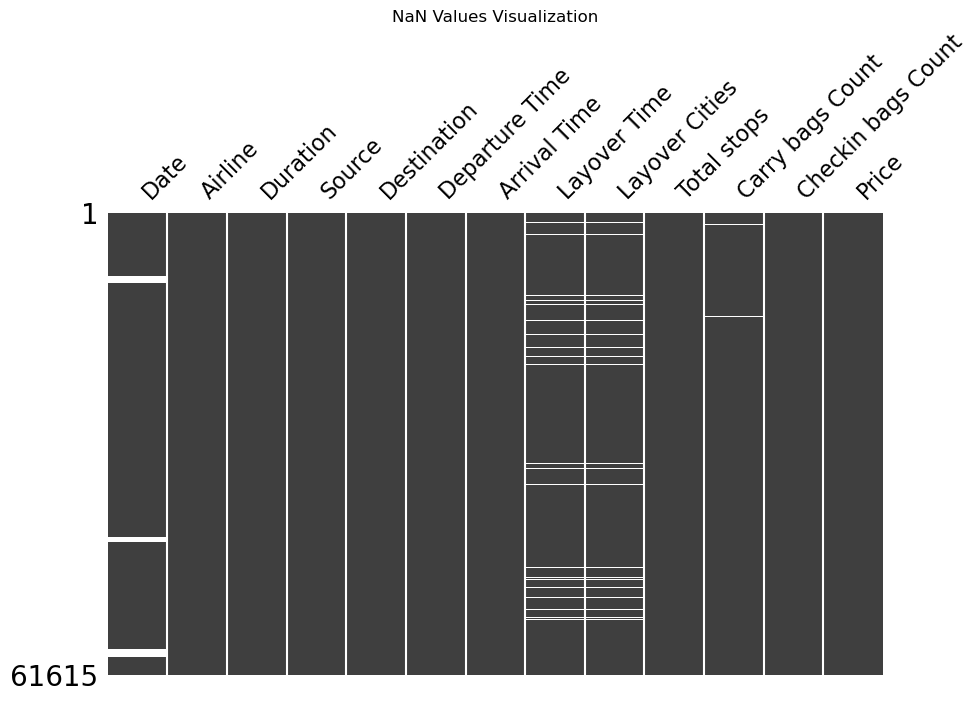

In [13]:
#a matrix visualization of missing values
msno.matrix(df, figsize=(10, 6), sparkline=False)
plt.title("NaN Values Visualization")
plt.show()

5.5% of data in Layover cities and Layover Time features have Nan values and 0.7% in carry bag count and 0.03 in checkin bag count. 
Lets check Layover Time and Layover cities data where there are null values

In [14]:
df_with_nulls = df[(df['Layover Time'].isna()) & (df['Total stops'] != 0)]
df_with_nulls.head()

,Date,Airline,Duration,Source,Destination,Departure Time,Arrival Time,Layover Time,Layover Cities,Total stops,Carry bags Count,Checkin bags Count,Price


In [15]:
df_with_nulls = df[(df['Layover Cities'].isna()) & (df['Total stops'] != 0)]
df_with_nulls.head()

,Date,Airline,Duration,Source,Destination,Departure Time,Arrival Time,Layover Time,Layover Cities,Total stops,Carry bags Count,Checkin bags Count,Price


It is observed that where ever the Layover cities and Layover Time value is NaN, Total stops is 0 which suggests that If there is no  stops then there will be no Layover cities or Layover Time.

We decided to drop Layover cities col since it gives less impact to get best deal of flights.

For Layover Time, change_time_to_minutes function will change the data in layover time to minutes. i.e 1h00m --> 60

In [16]:
#Handling null values
def drop_cols(data,col):
    data.drop(col, axis=1, inplace=True)

In [17]:
drop_cols(df,'Layover Cities')

In [18]:
df.head()

,Date,Airline,Duration,Source,Destination,Departure Time,Arrival Time,Layover Time,Total stops,Carry bags Count,Checkin bags Count,Price
0,2024-03-01,Lufthansa,10h 30m,Los Angeles,London,19:00:00,13:30:00,NaN,0.0,1.0,0.0,507
1,2024-03-01,WestJet,21h 30m,Los Angeles,London,07:00:00,12:30:00,9h 41m,1.0,1.0,0.0,393
2,2024-03-01,United Airlines,10h 30m,Los Angeles,London,19:00:00,13:30:00,NaN,0.0,1.0,0.0,558
3,2024-03-01,Austrian Airlines,10h 30m,Los Angeles,London,19:00:00,13:30:00,NaN,0.0,1.0,1.0,758
4,2024-03-01,Brussels Airlines,10h 30m,Los Angeles,London,19:00:00,13:30:00,NaN,0.0,1.0,1.0,758


In [19]:
#function to convert time to total minutes time
def convert_time_to_minutes(col):
    times = col.split(',')  # split by commas to get individual times
    total_minutes = 0
    for time in times:
        parts = time.split()  # split each  time by whitespace
        for part in parts:
            if 'h' in part:
                total_minutes += int(part.strip('h')) * 60 #converting hours to mins
            elif 'm' in part:
                total_minutes += int(part.strip('m')) #adding mins to total_minutes
    return total_minutes


In [20]:
#applying function to Layover Time
df['Layover Time'] = df['Layover Time'].astype(str)
df['Layover Time'] = df['Layover Time'].apply(convert_time_to_minutes)

In [21]:
#check the Layover Time
df.head()

,Date,Airline,Duration,Source,Destination,Departure Time,Arrival Time,Layover Time,Total stops,Carry bags Count,Checkin bags Count,Price
0,2024-03-01,Lufthansa,10h 30m,Los Angeles,London,19:00:00,13:30:00,0,0.0,1.0,0.0,507
1,2024-03-01,WestJet,21h 30m,Los Angeles,London,07:00:00,12:30:00,581,1.0,1.0,0.0,393
2,2024-03-01,United Airlines,10h 30m,Los Angeles,London,19:00:00,13:30:00,0,0.0,1.0,0.0,558
3,2024-03-01,Austrian Airlines,10h 30m,Los Angeles,London,19:00:00,13:30:00,0,0.0,1.0,1.0,758
4,2024-03-01,Brussels Airlines,10h 30m,Los Angeles,London,19:00:00,13:30:00,0,0.0,1.0,1.0,758


Now Handling null values in Carry bags Count and Checkin bags Count by grouping each airlines and replacing Nan with mode values. This is to get how each airplane eg Emirates given carry bag count and checkin bag count for most of its flights.

Handling Nan values with fill_nan function which fill the nan values with mode values f that feature grouping by airplanes


In [22]:
#function to fill nan values
def fill_nan(df, groupby_column, column_to_fill):
    # Calculate mode values grouped by the Airplane column
    mode_values = df.groupby(groupby_column)[column_to_fill].transform(lambda x: x.mode().iloc[0])
    # Fill NaN values with mode values
    df[column_to_fill] = df[column_to_fill].fillna(mode_values)
    return df

In [23]:
# Call the functions 
df = fill_nan(df, 'Airline', 'Carry bags Count')
df = fill_nan(df, 'Airline', 'Checkin bags Count')

In [24]:
#checking the null values again
df.isna().mean()

Date                  0.04137
Airline               0.00000
Duration              0.00000
Source                0.00000
Destination           0.00000
Departure Time        0.00000
Arrival Time          0.00000
Layover Time          0.00000
Total stops           0.00000
Carry bags Count      0.00000
Checkin bags Count    0.00000
Price                 0.00000
dtype: float64

### Feature Extraction

Chnaging the values in some features to extract more information. Duration features shows time as 1h 00m which we use the change_time_to_minutes function to get continuos values of total minutes

In [25]:
#Applying  convert_time_to_minutes function to duration col to get total minutes
df['Duration'] = df['Duration'].astype(str) 
df['Duration'] = df['Duration'].apply(convert_time_to_minutes)

In [26]:
#checking the function
df.tail()
print(df.dtypes)


Date                  datetime64[ns]
Airline                       object
Duration                       int64
Source                        object
Destination                   object
Departure Time                object
Arrival Time                  object
Layover Time                   int64
Total stops                  float64
Carry bags Count             float64
Checkin bags Count           float64
Price                          int64
dtype: object


Adding a new feature `price_permin_OnAir` which will gives the `price for each flight per minute` during the travel that means removing layover time and `multipling` it with the `ratio of baggage and number of stops`. This is to normalise the price factor for all flights despite of their duration and also can be used as a deciding factor at the end to give ratings to the flight deal.

In [27]:
df['Price_Per_Min_OnAir'] = df['Price']/ (df['Duration'] - df['Layover Time'])*((1+df['Carry bags Count']+ df['Checkin bags Count'])/1+df['Total stops'])
#df = df.drop('Price', axis=1)

Extracting additional features from Date like date, month, year and day of week

In [28]:
#Extrating Date,month,year and day of week from Date col
def extract_date_components(data, col):
    data[col + '_year'] = data[col].dt.year
    data[col + '_month'] = data[col].dt.month
    data[col + '_day'] = data[col].dt.day
    data[col + '_day_of_week'] = data[col].dt.dayofweek

    # Drop the original column
    data.drop(col, axis=1, inplace=True)

In [29]:
#applying the function
extract_date_components(df, 'Date')

Extracting the time of day using departure time and arrival time to see how pries varries accordingly 

In [30]:
#extracting time 
def categorize_time(time):
    hour = int(time.split(':')[0])
    if 0 <= hour < 4:
        return 'Midnight'
    elif 4 <= hour < 7:
        return 'Early Morning'
    elif 7 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 20:
        return 'Evening'
    else:
        return 'Night'

In [31]:
# Create a new column 'Departure Time New' to categorize departure times and 'Arrival Time New'to categorize Arrival Time
df['Departure Time New'] = df['Departure Time'].apply(categorize_time)
df['Arrival Time New'] = df['Arrival Time'].apply(categorize_time)

Now dropping the original columns of departure time and arrival time, also Date_year since our data is from 2024 so it will be unique value

In [32]:
#dropping columns
drop_cols(df,'Departure Time')
drop_cols(df,'Arrival Time')
drop_cols(df,'Date_year')

In [33]:
#checking the df
df.head()

,Airline,Duration,Source,Destination,Layover Time,Total stops,Carry bags Count,Checkin bags Count,Price,Price_Per_Min_OnAir,Date_month,Date_day,Date_day_of_week,Departure Time New,Arrival Time New
0,Lufthansa,630,Los Angeles,London,0,0.0,1.0,0.0,507,1.609524,3.0,1.0,4.0,Evening,Afternoon
1,WestJet,1290,Los Angeles,London,581,1.0,1.0,0.0,393,1.662906,3.0,1.0,4.0,Morning,Afternoon
2,United Airlines,630,Los Angeles,London,0,0.0,1.0,0.0,558,1.771429,3.0,1.0,4.0,Evening,Afternoon
3,Austrian Airlines,630,Los Angeles,London,0,0.0,1.0,1.0,758,3.609524,3.0,1.0,4.0,Evening,Afternoon
4,Brussels Airlines,630,Los Angeles,London,0,0.0,1.0,1.0,758,3.609524,3.0,1.0,4.0,Evening,Afternoon


In [34]:
#checking the modified shape of df
df.shape

(61615, 15)

Step 3:  use proper plotting methods to demonstrate the distribution of various attributed (columns) in the data.

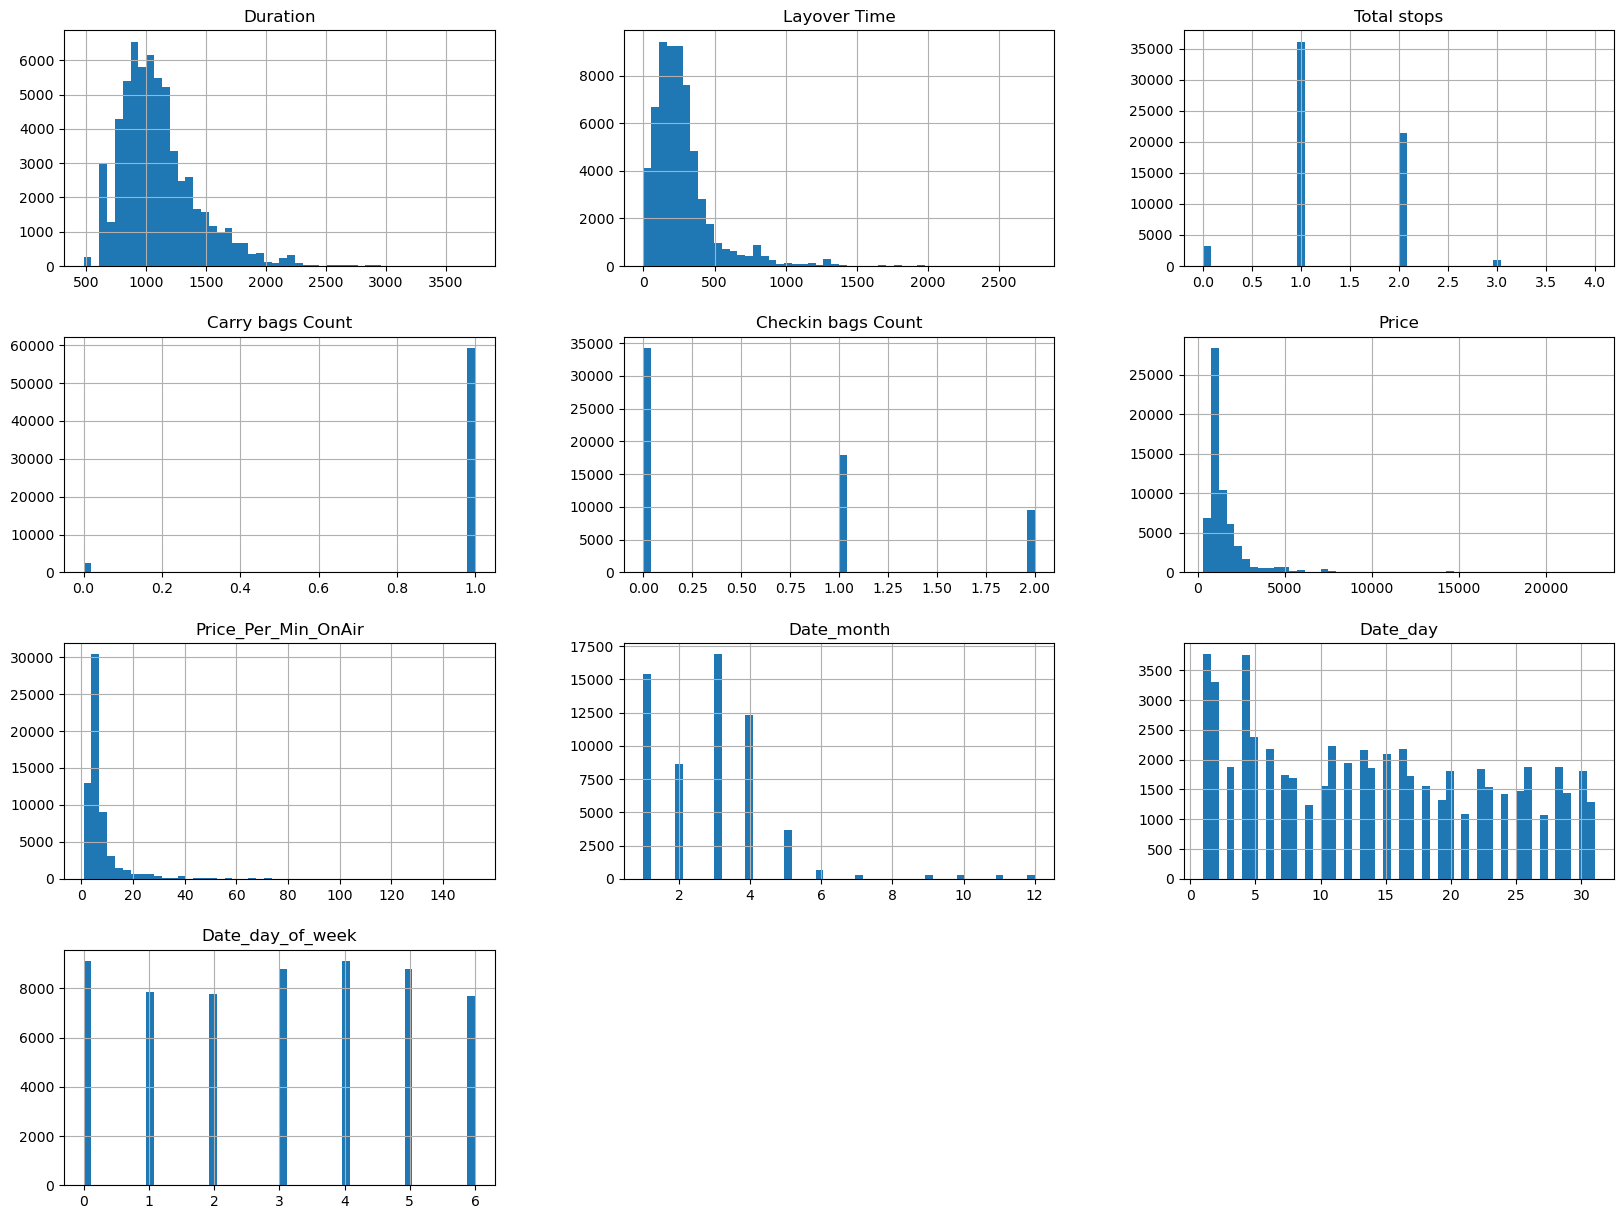

In [35]:
df.hist(bins=50, figsize=(20,15))
plt.show()

From the above plots it is observed that Duration, Layover Time and Price are Continuous columns while others are Categorical columns.

Total stops, Checkin bag count, Carry bag count, Departure Time New and Arrival Time New are ordinal features.

Airline,Source, Destination,Date_month, Date_day, Date_day_of_week are Nominal features 

In [36]:
#making a list of continuous and categorical columns
categorical_cols = ['Airline', 'Source', 'Destination', 'Departure Time New', 'Arrival Time New',
                       'Date_month', 'Date_day', 'Date_day_of_week','Total stops', 'Carry bags Count',
                       'Checkin bags Count']

#continuous_cols = ['Duration', 'Layover Time','Price', 'Price_Per_Min_OnAir']
continuous_cols = ['Duration', 'Layover Time', 'Price']

In [37]:
print("categorical_cols: ",categorical_cols)
print("continuous_cols: ",continuous_cols)

categorical_cols:  ['Airline', 'Source', 'Destination', 'Departure Time New', 'Arrival Time New', 'Date_month', 'Date_day', 'Date_day_of_week', 'Total stops', 'Carry bags Count', 'Checkin bags Count']
continuous_cols:  ['Duration', 'Layover Time', 'Price']


In [38]:
#making list of ordinal and nominal features
ordinal_cols =['Departure Time New', 'Arrival Time New']
nominal_cols = [ 'Source', 'Destination','Date_month', 'Date_day', 'Date_day_of_week']
print("ordinal_cols: ",ordinal_cols)
print("nominal_cols: ",nominal_cols)

ordinal_cols:  ['Departure Time New', 'Arrival Time New']
nominal_cols:  ['Source', 'Destination', 'Date_month', 'Date_day', 'Date_day_of_week']


Reason for not including Airplane in Nominal_cols list is because Airplane has some values like Emirate,Air Canada in case of two different flight after the layover. So in order to handle that case we are using separate function which is handling_airline_column to encode that feature 

Step 4: pandas profiling 

In [39]:
from pandas_profiling import ProfileReport

profile = ProfileReport(df)

profile.to_file("pandas_profilling.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [40]:
# Remove duplicate rows based on all columns
df = df.drop_duplicates()

### Encoding

step 5: Encoding categorical features

In [41]:
nominal_cols

['Source', 'Destination', 'Date_month', 'Date_day', 'Date_day_of_week']

Encoding the above nominal columns using one hot encoding technique.

In [42]:
#function to do one hot encoding
def one_hot_encode(df, nominal_cols):
    for column in nominal_cols:
        #creating dummies
        one_hot = pd.get_dummies(df[column], prefix=column, drop_first=True)        
        # Concatenate the one-hot encoded columns with the original DataFrame
        df = pd.concat([df, one_hot], axis=1)       
        # Drop the original categorical column
        df.drop(column, axis=1, inplace=True)
    return df
#function to encode Airplane Feature
def handling_airline_column(df, column_name):
    df[column_name] = df[column_name].astype(str)
    df[column_name] = df[column_name].str.split(',')
    df[column_name] = df[column_name].apply(lambda x: [item.strip("[]'' ").replace(" ", "") for item in x])
    mlb = MultiLabelBinarizer()
    array_out = mlb.fit_transform(df[column_name])
    df_out = pd.DataFrame(data=array_out, columns=mlb.classes_)    
    # Reset the index of df before concatenation
    df = df.reset_index(drop=True)    
    df_concatenated = pd.concat([df, df_out], axis=1)
    df_concatenated.drop(column_name, axis=1, inplace=True)  # Drop the original column
    return df_concatenated


In [43]:
df = one_hot_encode(df, nominal_cols)
df = handling_airline_column(df, 'Airline')

Applying Label encoding on ordinal columns

In [44]:
from sklearn.preprocessing import LabelEncoder
#function to do Label encoding on ordinal cols
def label_encode(df, ordinal_cols):

    df_encoded = df.copy()
    label_encoder = LabelEncoder()

    for column in ordinal_cols:
        df_encoded[column] = label_encoder.fit_transform(df_encoded[column])

    return df_encoded


In [45]:
#applying function
df = label_encode(df, ordinal_cols)

In [46]:
#checking the new shape of df
df.shape

(59281, 177)

In [47]:
#checking the values of df
df.head()

,Duration,Layover Time,Total stops,Carry bags Count,Checkin bags Count,Price,Price_Per_Min_OnAir,Departure Time New,Arrival Time New,Source_Changde,...,Vueling,WestJet,WestJetEncore,WizzAir,WizzAirMalta,WizzAirUK,airBaltic,easyJet,flydubai,flynas
0,630,0,0.0,1.0,0.0,507,1.609524,2,0,False,...,0,0,0,0,0,0,0,0,0,0
1,1290,581,1.0,1.0,0.0,393,1.662906,4,0,False,...,0,1,0,0,0,0,0,0,0,0
2,630,0,0.0,1.0,0.0,558,1.771429,2,0,False,...,0,0,0,0,0,0,0,0,0,0
3,630,0,0.0,1.0,1.0,758,3.609524,2,0,False,...,0,0,0,0,0,0,0,0,0,0
4,630,0,0.0,1.0,1.0,758,3.609524,2,0,False,...,0,0,0,0,0,0,0,0,0,0


In [48]:
#checking new columns after encoding
df.columns

Index(['Duration', 'Layover Time', 'Total stops', 'Carry bags Count',
       'Checkin bags Count', 'Price', 'Price_Per_Min_OnAir',
       'Departure Time New', 'Arrival Time New', 'Source_Changde',
       ...
       'Vueling', 'WestJet', 'WestJetEncore', 'WizzAir', 'WizzAirMalta',
       'WizzAirUK', 'airBaltic', 'easyJet', 'flydubai', 'flynas'],
      dtype='object', length=177)

### Outliers

Step 6: Identify and Handling outliers using IQR, Trimming and Log trandformation techniques

In [49]:
#checking the outliers using describe function
df[continuous_cols].describe()

,Duration,Layover Time,Price
count,59281.000000,59281.000000,59281.000000
mean,1095.496989,260.639648,1568.475734
std,319.479761,214.895647,1517.628621
min,480.000000,0.000000,300.000000
25%,880.000000,133.000000,929.000000
50%,1040.000000,220.000000,1108.000000
75%,1240.000000,320.000000,1660.000000
max,3745.000000,2750.000000,22788.000000


In [50]:
#function to visualize the outliers of continuous columns
def visualize_outliers(df):
    #visualizing the outliers using box plot
    columns_to_plot = continuous_cols
    # Loop through each column and plot the box plot
    print("visualizing outliers before handling them")
    for i, col in enumerate(columns_to_plot):
      plt.figure(figsize=(15,10))
      plt.subplots_adjust(wspace=0.5, hspace=0.5)
      sns.boxplot(data=df[col])
      plt.title(f'Boxplot of {col}')
      plt.xlabel(col)
      plt.ylabel('Value')
      print(plt.show())


visualizing outliers before handling them


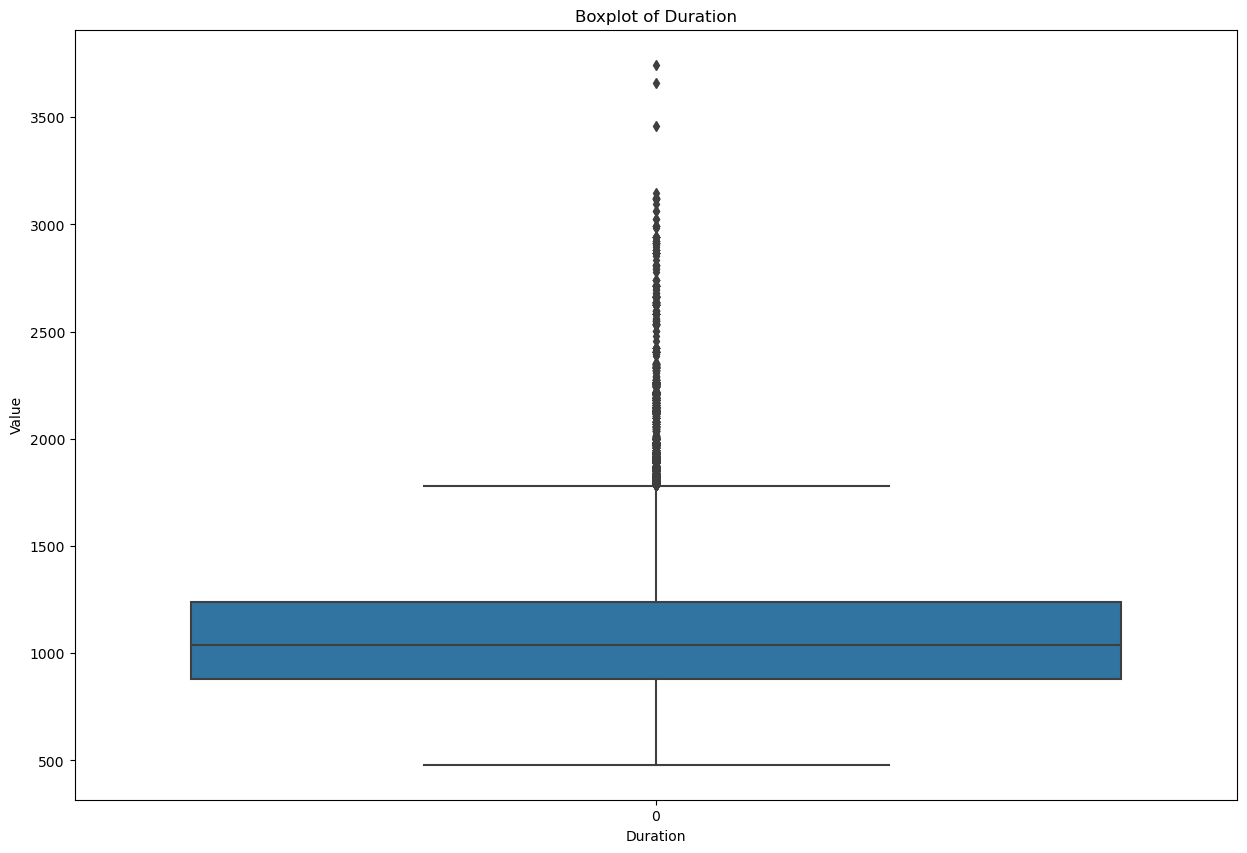

None


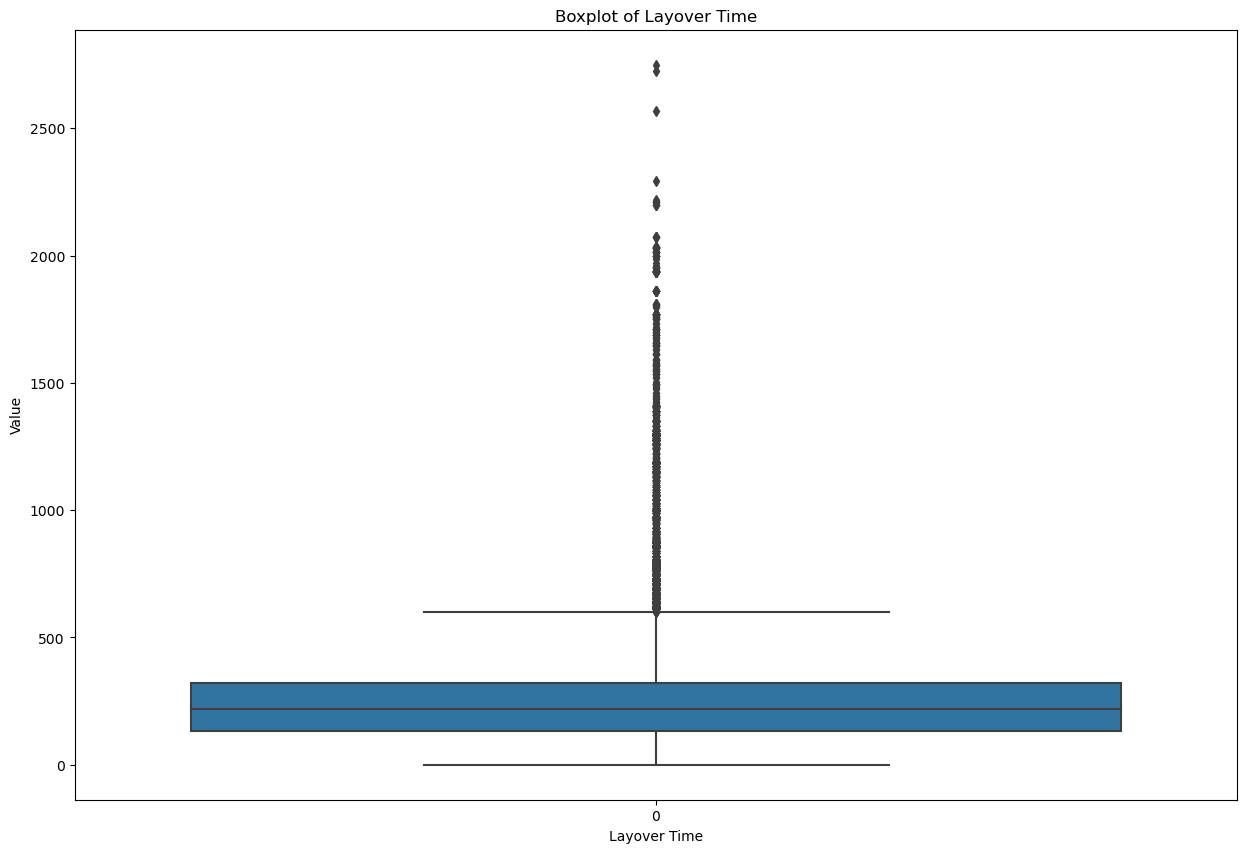

None


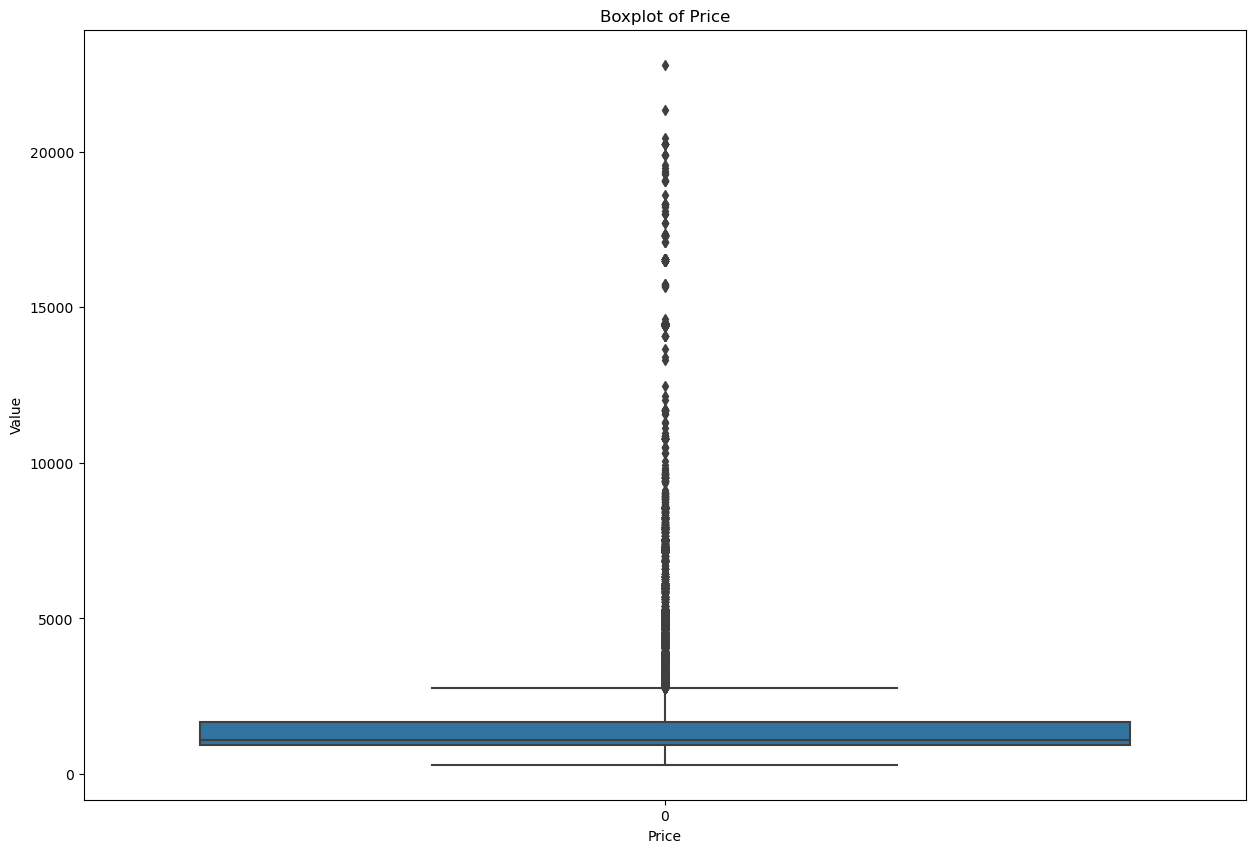

None


In [51]:
#Applying function
visualize_outliers(df)

From the above box plots on continous columns of df we can use all 3 have some outliers. In order to handle them we will use handle_outliers in which it will create copy of df and applying all three techniques of handling outliers on df and save 3different df's.

Step7: The following techniques used to address the outliers

1.Quantile-based Flooring and Capping: By taking 

2.Trimming

3.Log Transformation


In [52]:
#function to handle outliers 
def handle_outliers(df, cols_to_handle, method='quantile', lower_trim=0.05, upper_trim=0.95):
    df_copy = df.copy()

    for col in cols_to_handle:
        if method == 'quantile':
            q1 = df_copy[col].quantile(0.05)
            q99 = df_copy[col].quantile(0.90)
            df_copy[col] = np.clip(df_copy[col], q1, q99)
        elif method == 'trim':
            lower_threshold = df_copy[col].quantile(lower_trim)
            upper_threshold = df_copy[col].quantile(upper_trim)
            df_copy = df_copy[(df_copy[col] >= lower_threshold) & (df_copy[col] <= upper_threshold)]
        elif method == 'log':
            df_copy[col] = np.log1p(df_copy[col])  
    return df_copy

In [53]:
#Applying function using 3 tecniques and saving them seperately 
df_IQR = handle_outliers(df, continuous_cols, method='quantile')
df_trimmed = handle_outliers(df, continuous_cols, method='trim')
df_logged = handle_outliers(df, continuous_cols, method='log')

In [54]:
#function to visualize the difference of outcomes from 3 techniques
def visualize_outlier_handling(df_original, df_handled_quantile, df_handled_trim, df_handled_log, column_name):
    fig, axes = plt.subplots(1, 4, figsize=(18, 5))
    
    # Plot original data
    sns.boxplot(data=df_original, x=column_name, ax=axes[0])
    axes[0].set_title('Original Data\nShape: {}'.format(df_original.shape))

    # Plot Quantile-based Flooring and Capping
    sns.boxplot(data=df_handled_quantile, x=column_name, ax=axes[1])
    axes[1].set_title('Quantile-based Flooring and Capping\nShape: {}'.format(df_handled_quantile.shape))

    # Plot Trimming
    sns.boxplot(data=df_handled_trim, x=column_name, ax=axes[2])
    axes[2].set_title('Trimming\nShape: {}'.format(df_handled_trim.shape))

    # Plot Log Transformation
    sns.boxplot(data=df_handled_log, x=column_name, ax=axes[3])
    axes[3].set_title('Log Transformation\nShape: {}'.format(df_handled_log.shape))

    plt.show()


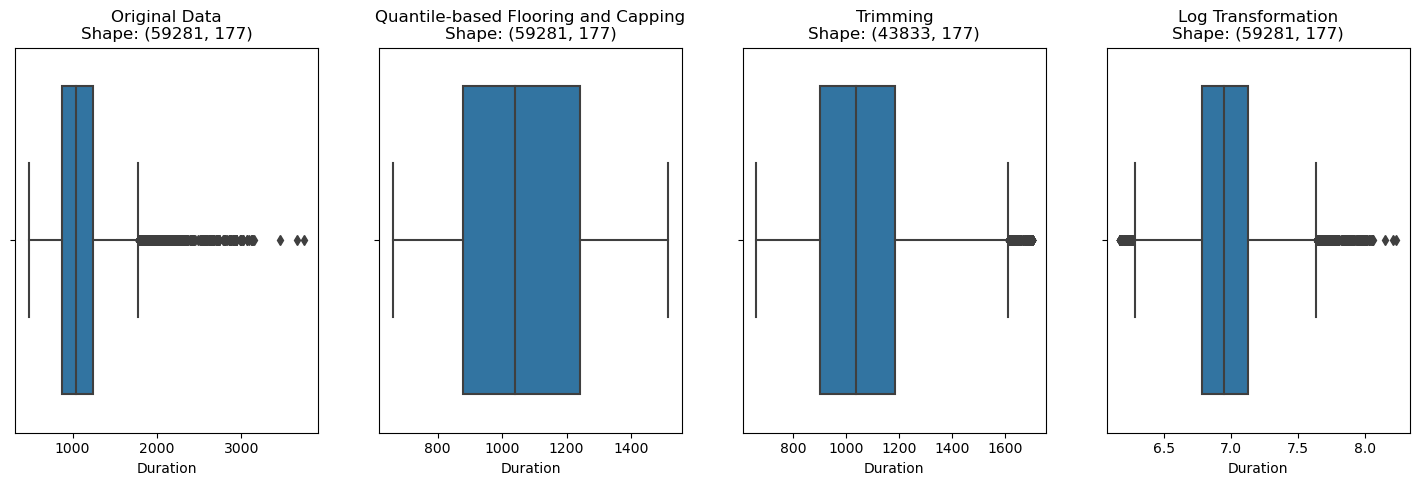

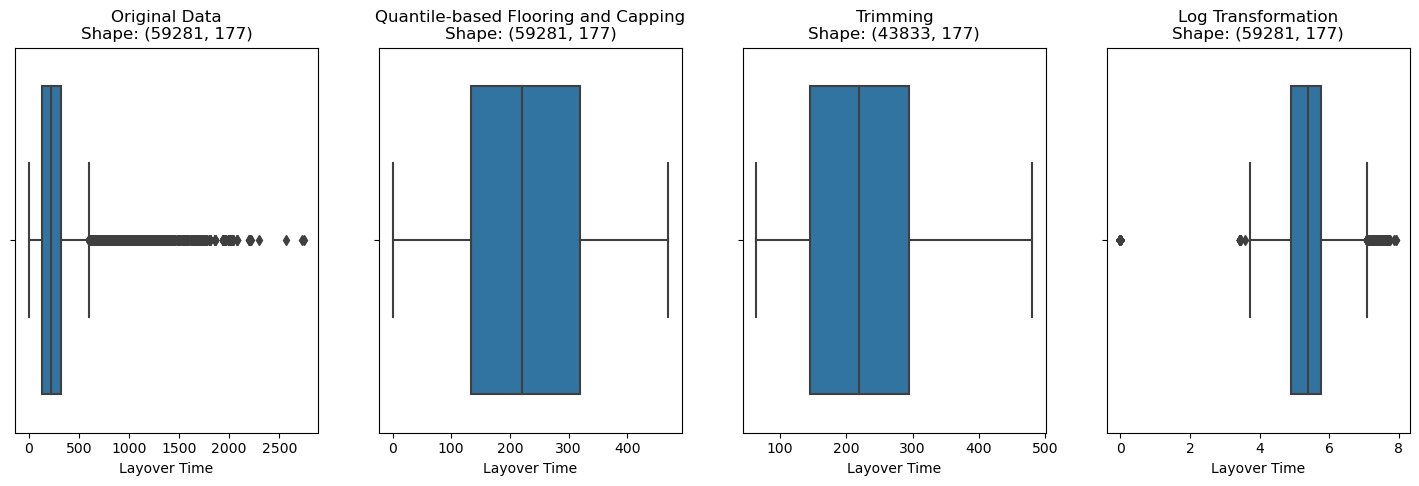

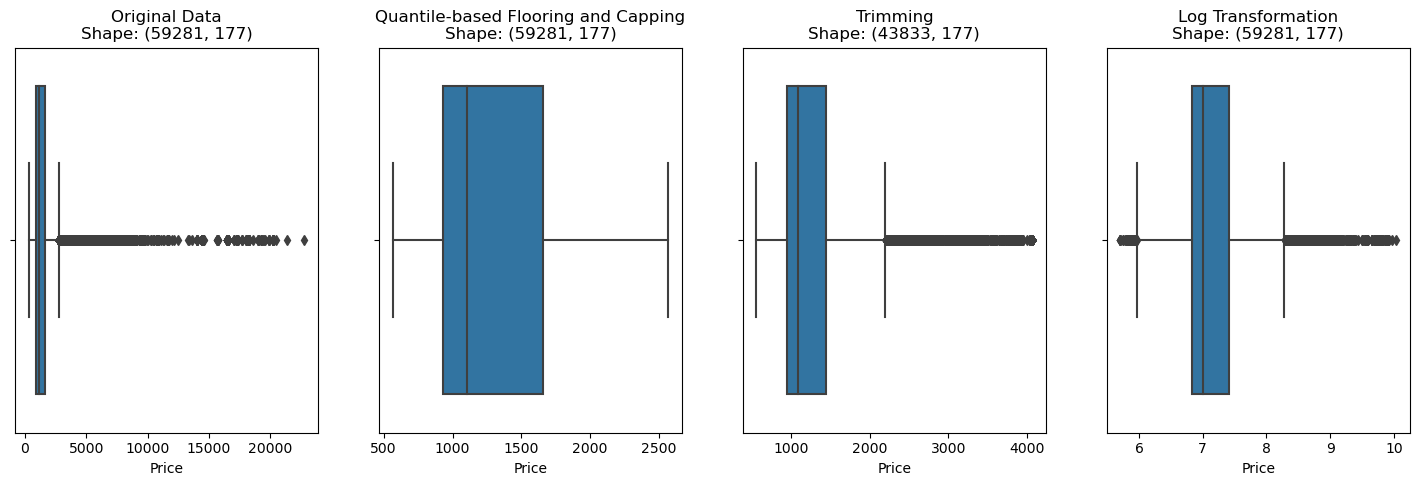

In [55]:
#applying function
for col in continuous_cols:
    visualize_outlier_handling(df, df_IQR, df_trimmed, df_logged, col)


from above plots we can conclude the following points

1. By using IQR method with q1 = 0.5 and q3 = 0.90, we can able to handle outliers.
2. By using trimming method we can able to hand;le outliers but we are loosing some data which will bias the model
3. By using Log transformation there are soo many outliers which didnt got handled.

We choose to go with IQR method which seems to be appropriate for our dataset 

In [56]:
df_IQR.head()

,Duration,Layover Time,Total stops,Carry bags Count,Checkin bags Count,Price,Price_Per_Min_OnAir,Departure Time New,Arrival Time New,Source_Changde,...,Vueling,WestJet,WestJetEncore,WizzAir,WizzAirMalta,WizzAirUK,airBaltic,easyJet,flydubai,flynas
0,660,0,0.0,1.0,0.0,564,1.609524,2,0,False,...,0,0,0,0,0,0,0,0,0,0
1,1290,470,1.0,1.0,0.0,564,1.662906,4,0,False,...,0,1,0,0,0,0,0,0,0,0
2,660,0,0.0,1.0,0.0,564,1.771429,2,0,False,...,0,0,0,0,0,0,0,0,0,0
3,660,0,0.0,1.0,1.0,758,3.609524,2,0,False,...,0,0,0,0,0,0,0,0,0,0
4,660,0,0.0,1.0,1.0,758,3.609524,2,0,False,...,0,0,0,0,0,0,0,0,0,0


### Data Normalisation

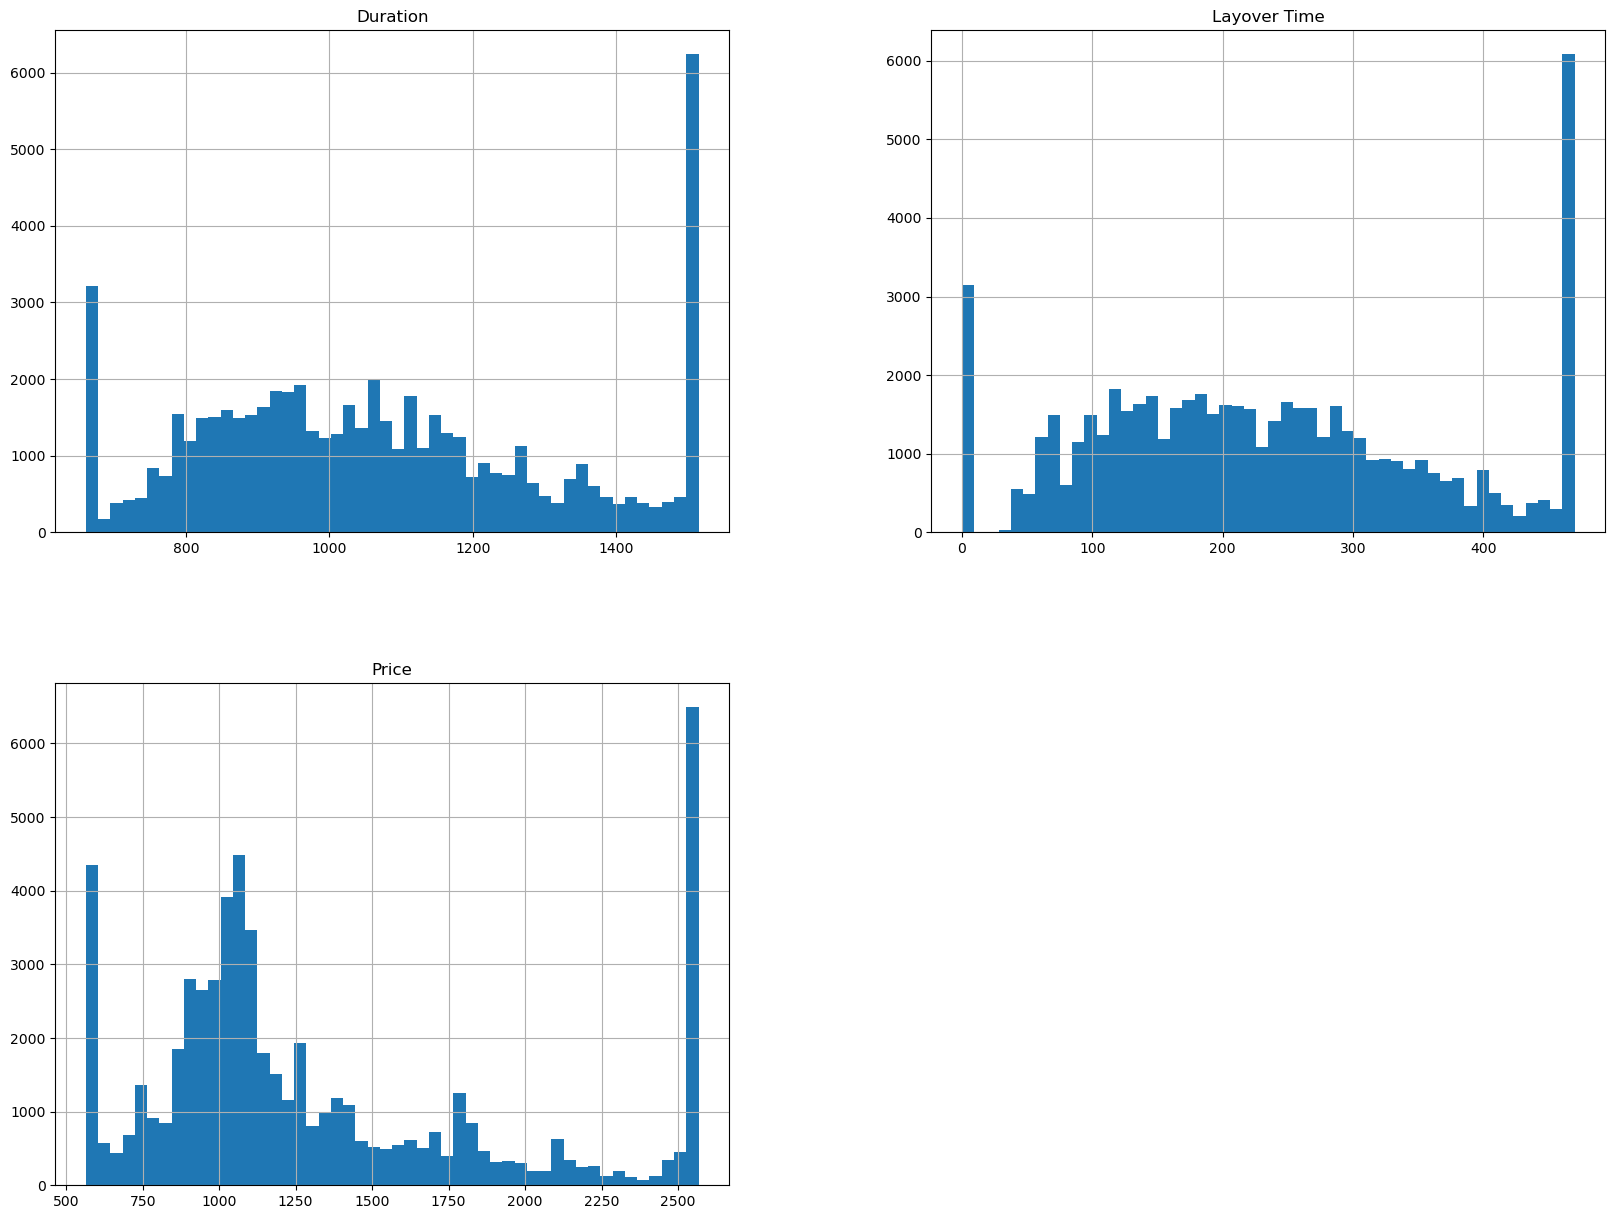

In [57]:
df_IQR[continuous_cols].hist(bins=50, figsize=(20,15))
plt.show()

By above plot we can tell that continuous columns are right skeweed and needs to be normalised, we choose minmax scaler technique to perform normalisation

In [58]:
from sklearn.preprocessing import MinMaxScaler

def normalize_continuous_cols(df, continuous_cols):
    df_normalized = df.copy()
    #using the MinMaxScaler
    scaler = MinMaxScaler()
    # Normalize specified columns
    df_normalized[continuous_cols] = scaler.fit_transform(df_normalized[continuous_cols])
    return df_normalized

In [59]:
#applying function
df = normalize_continuous_cols(df_IQR, continuous_cols)

In [60]:
df.head()

,Duration,Layover Time,Total stops,Carry bags Count,Checkin bags Count,Price,Price_Per_Min_OnAir,Departure Time New,Arrival Time New,Source_Changde,...,Vueling,WestJet,WestJetEncore,WizzAir,WizzAirMalta,WizzAirUK,airBaltic,easyJet,flydubai,flynas
0,0.000000,0.0,0.0,1.0,0.0,0.000000,1.609524,2,0,False,...,0,0,0,0,0,0,0,0,0,0
1,0.736842,1.0,1.0,1.0,0.0,0.000000,1.662906,4,0,False,...,0,1,0,0,0,0,0,0,0,0
2,0.000000,0.0,0.0,1.0,0.0,0.000000,1.771429,2,0,False,...,0,0,0,0,0,0,0,0,0,0
3,0.000000,0.0,0.0,1.0,1.0,0.096855,3.609524,2,0,False,...,0,0,0,0,0,0,0,0,0,0
4,0.000000,0.0,0.0,1.0,1.0,0.096855,3.609524,2,0,False,...,0,0,0,0,0,0,0,0,0,0


### Dimentionality Reduction

Since we got 177 columns after data wrangling, it is ideal to perform dimentionality reduction before feeding this to model. We are apply PCA to acheive this

In [61]:
from sklearn.decomposition import PCA

In [62]:
df.describe()

,Duration,Layover Time,Total stops,Carry bags Count,Checkin bags Count,Price,Price_Per_Min_OnAir,Departure Time New,Arrival Time New,ANA,...,Vueling,WestJet,WestJetEncore,WizzAir,WizzAirMalta,WizzAirUK,airBaltic,easyJet,flydubai,flynas
count,59281.000000,59281.000000,59281.000000,59281.000000,59281.000000,59281.000000,59281.000000,59281.000000,59281.000000,59281.000000,...,59281.000000,59281.000000,59281.000000,59281.000000,59281.000000,59281.000000,59281.000000,59281.000000,59281.000000,59281.000000
mean,0.479325,0.495701,1.299067,0.960915,0.592500,0.383314,7.453570,2.864577,2.786896,0.001316,...,0.011656,0.007895,0.000692,0.000523,0.000540,0.000017,0.000017,0.005044,0.005010,0.000034
std,0.289565,0.280706,0.586609,0.193799,0.738509,0.297041,8.082320,1.722934,1.850169,0.036250,...,0.107334,0.088501,0.026290,0.022862,0.023228,0.004107,0.004107,0.070841,0.070605,0.005808
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.862626,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.257310,0.282979,1.000000,1.000000,0.000000,0.182227,4.096310,2.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.444444,0.468085,1.000000,1.000000,0.000000,0.271593,5.478375,4.000000,3.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.678363,0.680851,2.000000,1.000000,1.000000,0.547179,7.239625,4.000000,4.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,4.000000,1.000000,2.000000,1.000000,152.396804,5.000000,5.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [63]:
#performing PCA
pca = PCA(n_components=10)
pca.fit(df)
PCA_df = pd.DataFrame(pca.transform(df))
PCA_df.describe()

,0,1,2,3,4,5,6,7,8,9
count,5.928100e+04,5.928100e+04,5.928100e+04,5.928100e+04,5.928100e+04,5.928100e+04,5.928100e+04,5.928100e+04,5.928100e+04,5.928100e+04
mean,-1.841051e-16,-1.821874e-16,-9.588809e-17,-2.262959e-16,-2.368436e-16,2.445146e-17,-1.764341e-16,6.496418e-17,7.095719e-17,-6.136838e-17
std,8.095060e+00,1.858020e+00,1.723789e+00,8.351122e-01,6.926370e-01,6.046888e-01,4.935583e-01,4.608976e-01,4.196173e-01,4.116240e-01
min,-6.605390e+00,-2.933524e+00,-2.314846e+00,-2.164460e+00,-1.997620e+00,-1.661102e+00,-1.283277e+00,-1.075080e+00,-1.227928e+00,-1.242471e+00
25%,-3.384758e+00,-1.239849e+00,-1.183338e+00,-7.374516e-01,-5.186285e-01,-4.166081e-01,-3.553655e-01,-2.817430e-01,-2.724620e-01,-2.570284e-01
50%,-1.978690e+00,-4.094833e-01,-1.073757e+00,6.618657e-02,-5.370603e-02,-8.767331e-02,-7.731682e-02,-5.030498e-02,-3.974752e-02,-1.854256e-02
75%,-1.930362e-01,1.786855e+00,9.282520e-01,7.056360e-01,5.710470e-01,3.605482e-01,3.586838e-01,1.599534e-01,2.175828e-01,1.960741e-01
max,1.447179e+02,2.960321e+00,5.250999e+00,6.269783e+00,2.048046e+00,1.904657e+00,1.384115e+00,1.802481e+00,2.080969e+00,1.709265e+00


In [64]:
#visualize the Explained Variance and cumulative variance
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

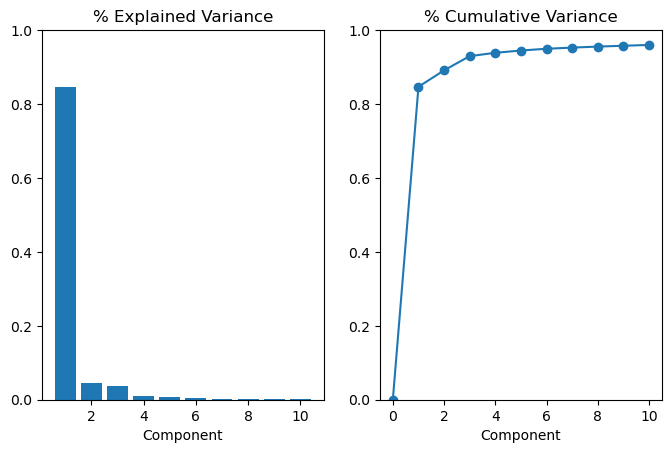

In [65]:
plot_variance(pca);

### <span style="color:#FF5733">Using Elbow method to figure the appropriate number of clusters</span>

Performing elbow method to find the k value before doing K means Clustering

In [66]:
from sklearn.cluster import KMeans
sse = []
for k in range(1,10):
    km = KMeans(n_clusters=k, n_init=10)
    km.fit(PCA_df)
    sse.append(km.inertia_)

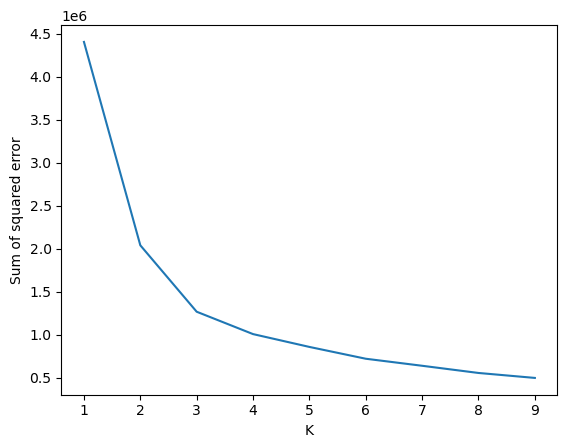

In [67]:
#visualizing Elbow method
plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(range(1,10),sse)

<b><span style="color:#A569BD">According to the ELbow graph, five clusters will work best for this set of data. Till k = 5, we can see a steep curve and from 5 its kind going plane. And also since we are Rating the flight deals, we belive 5 is a good and commonly used number for rating </span><b>

Step 8: unsupervised learning method 

### K means Clustering

Applying kmean clustering on the data with k = 5 and appending it in the column `KMeans_Clusters`

In [68]:
#applying kmeans clustering
kmeans = KMeans(n_clusters=5)  #k value we got from elbow method
kmeans.fit(PCA_df)  
yhat_kmeans = kmeans.predict(PCA_df)

# Adding the K-Means clusters to the original dataframe
df["KMeans_Clusters"] = yhat_kmeans

### Evaluating the clusters

`silhouette_score` - It is easy to understand and interpret. It ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster.

`Davies-Bouldin Index` - It provides a relatively straightforward interpretation - a lower value indicates better clustering.

`Calinski-Harabasz Index` - It emphasizes both the separation between clusters and the compactness of clusters. Higher values indicate better-defined clusters.

In [69]:
from sklearn.metrics import silhouette_score

# Assuming 'df' is your DataFrame and 'KMeans_Clusters' is the column with cluster labels
data = df.drop('KMeans_Clusters', axis=1)  # Exclude the column with cluster labels
labels = df['KMeans_Clusters'].values

# Calculate silhouette score
silhouette_score_km = silhouette_score(data, labels)
print("Silhouette Score:", silhouette_score_km)


Silhouette Score: 0.20192169540443156


This score is good score since it is close to `1`

In [70]:
from sklearn.metrics import davies_bouldin_score

# Assuming 'data' is your dataset and 'labels' are the cluster labels
davies_score_km = davies_bouldin_score(data, labels)
print("Davies-Bouldin Index:", davies_score_km)


Davies-Bouldin Index: 1.2360284456566688


This score is good score since it is close to `0` 

In [71]:
from sklearn.metrics import calinski_harabasz_score

calinski_score_km = calinski_harabasz_score(data, labels)
print("Calinski-Harabasz Index:", calinski_score_km)


Calinski-Harabasz Index: 49786.01724206159


This score is good score since it has a higher value and higher value indicate a good cluster

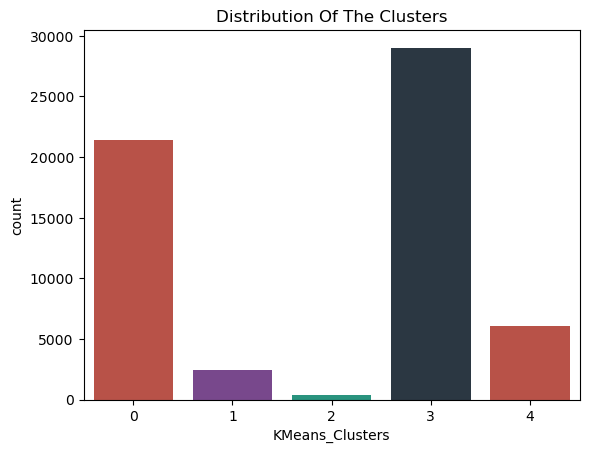

In [72]:
color_pallet = ["#CB4335", "#7D3C98", "#17A589" , "#273746"]

pl = sns.countplot(x=df["KMeans_Clusters"], palette= color_pallet)
pl.set_title("Distribution Of The Clusters")
plt.show()

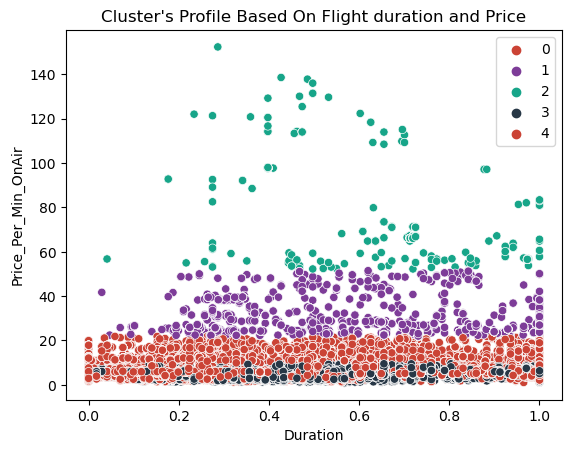

In [73]:
pl = sns.scatterplot(data = df,x=df["Duration"], y=df["Price_Per_Min_OnAir"],hue=df["KMeans_Clusters"], palette= color_pallet)
pl.set_title("Cluster's Profile Based On Flight duration and Price")
plt.legend()
plt.show()

The above scatter plot represents a better clustering of the data points on basis of the defined column `Price_Per_Min_OnAir` w.r.t. `Duration`

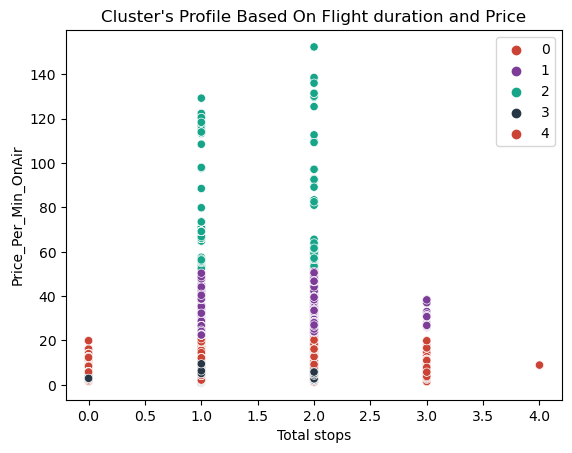

In [74]:
pl = sns.scatterplot(data = df,x=df["Total stops"], y=df["Price_Per_Min_OnAir"],hue=df["KMeans_Clusters"], palette= color_pallet)
pl.set_title("Cluster's Profile Based On Flight duration and Price")
plt.legend()
plt.show()

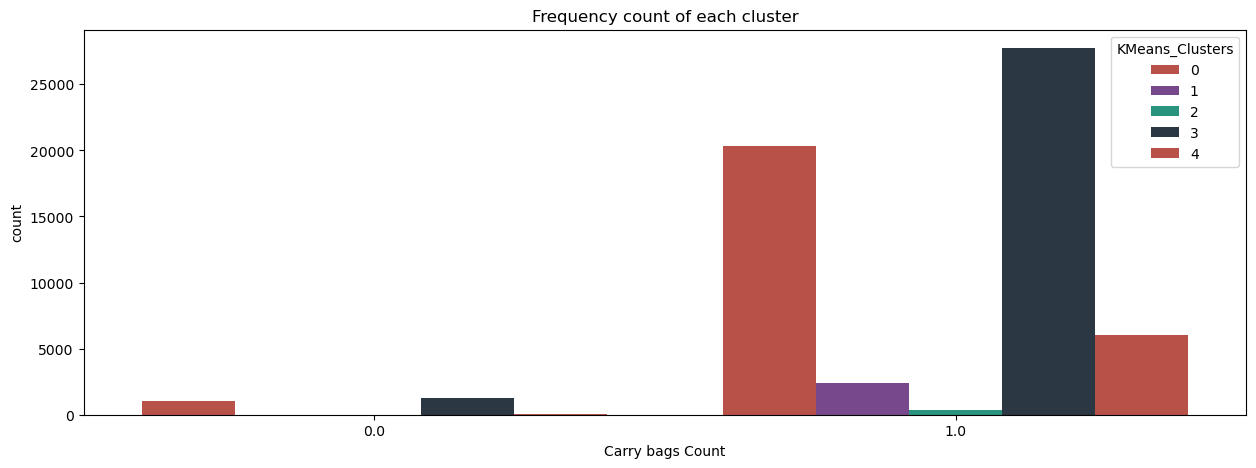

In [75]:
plt.figure(figsize=(15,5))
pl = sns.countplot(x=df["Carry bags Count"],hue=df["KMeans_Clusters"], palette= color_pallet)
pl.set_title("Frequency count of each cluster")
pl.set_xlabel("Carry bags Count")
plt.show()

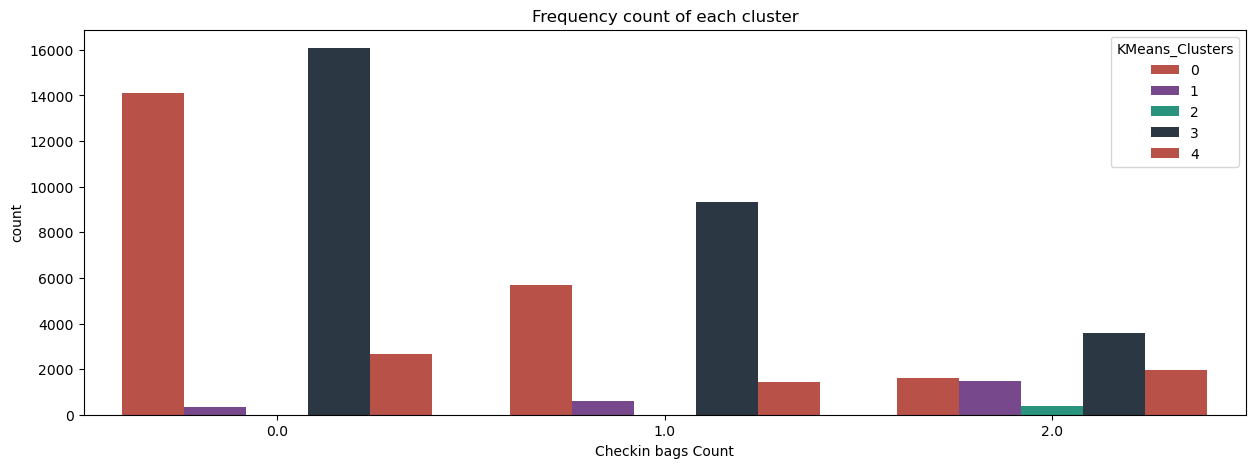

In [76]:
plt.figure(figsize=(15,5))
pl = sns.countplot(x=df["Checkin bags Count"],hue=df["KMeans_Clusters"], palette= color_pallet)
pl.set_title("Frequency count of each cluster")
pl.set_xlabel("Checkin bags Count")
plt.show()

# AgglomerativeClustering

The `agglomerative clustering` is the most common type of hierarchical clustering used to group objects in clusters based on their similarity. It’s also known as AGNES (Agglomerative Nesting). The algorithm starts by treating each object as a singleton cluster. Next, pairs of clusters are successively merged until all clusters have been merged into one big cluster containing all objects. The result is a tree-based representation of the objects, named dendrogram

In [80]:
from sklearn.cluster import AgglomerativeClustering

In [81]:
PCA_df.columns = PCA_df.columns.astype(str)
PCA_df

,0,1,2,3,4,5,6,7,8,9
0,-5.896745,2.925486,0.762425,0.952028,0.595970,0.648940,0.598415,0.455149,-0.146641,0.448524
1,-5.794068,2.831970,-1.270396,0.427732,-0.039117,-0.153537,0.819629,0.218734,-0.197549,0.052469
2,-5.740759,2.898624,0.763440,1.059182,0.607086,0.617456,0.678790,0.338742,-0.027808,0.263327
3,-3.864606,2.855604,0.764343,0.651639,1.363793,0.562034,0.617597,0.277202,-0.243839,0.272235
4,-3.865053,2.853596,0.761611,0.660742,1.373317,0.543907,0.623567,0.274115,-0.246420,0.274748
...,...,...,...,...,...,...,...,...,...,...
59276,20.153333,2.556585,-1.927482,-0.661717,0.448385,-0.599188,-0.567055,0.267350,-0.328635,-0.536727
59277,20.721806,2.550410,-1.917080,-0.651021,0.417993,-0.608691,-0.560180,0.250455,-0.330282,-0.550646
59278,19.634820,2.549610,-1.947133,-0.828104,0.475195,-0.643644,-0.610759,0.195989,-0.433279,-0.633931
59279,61.737424,2.450140,0.742499,1.640822,0.283513,0.702333,-0.884190,0.199875,-0.173829,-0.549366


In [83]:
#Initiating the Agglomerative Clustering model 
AC = AgglomerativeClustering(n_clusters=5)
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_df)
#PCA_df["Clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
df["Agg_Clusters"]= yhat_AC

In [84]:
from sklearn.metrics import silhouette_score

# Assuming 'df' is your DataFrame and 'KMeans_Clusters' is the column with cluster labels
X = df.drop('Agg_Clusters', axis=1)  # Exclude the column with cluster labels
labels = df['Agg_Clusters'].values

# Calculate silhouette score
silhouette_score_ac = silhouette_score(X, labels)
print("Silhouette Score:", silhouette_score_ac)


Silhouette Score: 0.23345461361286346


This score is good score since it is close to `1`

In [85]:
from sklearn.metrics import davies_bouldin_score

# Assuming 'data' is your dataset and 'labels' are the cluster labels
davies_score_ac = davies_bouldin_score(data, labels)
print("Davies-Bouldin Index:", davies_score_ac)


Davies-Bouldin Index: 1.1009096188188536


This score is good score since it is close to `0`

In [86]:
from sklearn.metrics import calinski_harabasz_score

calinski_score_ac = calinski_harabasz_score(data, labels)
print("Calinski-Harabasz Index:", calinski_score_ac)


Calinski-Harabasz Index: 46547.81689814521


This score is good score since it has a higher value and higher value indicate a good cluster

In [87]:
from matplotlib import colors
cmap = colors.ListedColormap(["#CB4335", "#3498db", "#2ecc71", "#e74c3c", "#f39c12"])


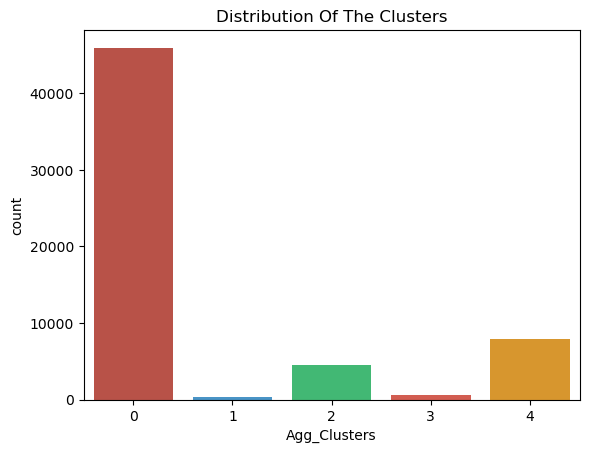

In [88]:
color_pallet = ["#CB4335", "#3498db", "#2ecc71", "#e74c3c", "#f39c12"]

pl = sns.countplot(x=df["Agg_Clusters"], palette= color_pallet)
pl.set_title("Distribution Of The Clusters")
plt.show()

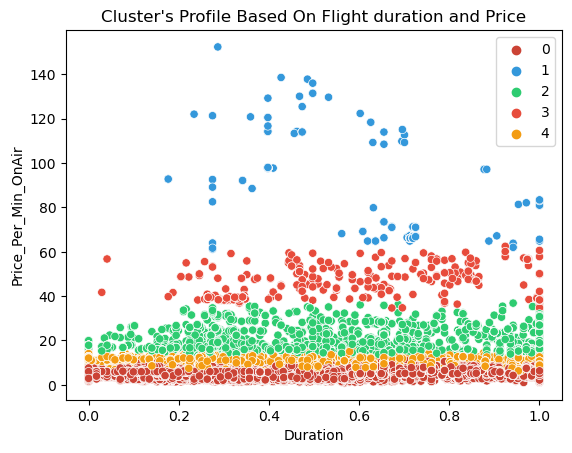

In [89]:

pl = sns.scatterplot(data = df,x=df["Duration"], y=df["Price_Per_Min_OnAir"],hue=df["Agg_Clusters"], palette= color_pallet)
pl.set_title("Cluster's Profile Based On Flight duration and Price")
plt.legend()
plt.show()

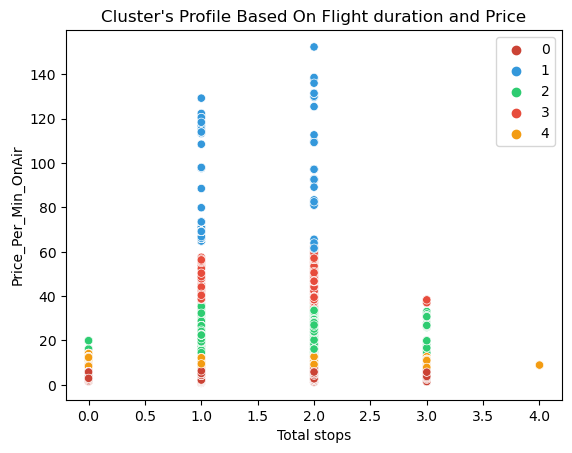

In [90]:
pl = sns.scatterplot(data = df,x=df["Total stops"], y=df["Price_Per_Min_OnAir"],hue=df["Agg_Clusters"], palette= color_pallet)
pl.set_title("Cluster's Profile Based On Flight duration and Price")
plt.legend()
plt.show()

# <span style="color:#FF5733">Getting insights from the various clusters found in the data</span> 
Considering that this grouping is unsupervised. We lack a labelled feature with which to assess or grade our model. This section aims to analyse the patterns in the clusters that were created and identify the types of patterns in the clusters.

## Firstly, let us have a look at the group distributions

In [91]:
pd.DataFrame(df["KMeans_Clusters"].value_counts())

,count
KMeans_Clusters,
3,29027
0,21373
4,6070
1,2437
2,374


In [92]:
pd.DataFrame(df["Agg_Clusters"].value_counts())

,count
Agg_Clusters,
0,45932
4,7948
2,4475
3,648
1,278


In [93]:
df[['Price_Per_Min_OnAir','Total stops']].groupby(df["KMeans_Clusters"]).describe()

Price_Per_Min_OnAir                                   \
                              count       mean        std        min   
KMeans_Clusters                                                        
0                           21373.0   5.094096   1.759721   1.071605   
1                            2437.0  29.932327   7.340899  21.934579   
2                             374.0  73.287566  19.750700  52.258252   
3                           29027.0   5.109711   1.701384   0.862626   
4                            6070.0  13.888760   3.228009   9.216450   

                                                             Total stops  \
                       25%        50%        75%         max       count   
KMeans_Clusters                                                            
0                 3.846429   4.986111   6.217391    9.940541     21373.0   
1                24.352941  26.887336  33.310992   51.491525      2437.0   
2                60.256191  66.824074  73.506667  152.396804       374.0   
3                 3.921176   4.973621   6.330935    9.847645     29027.0   
4                11.211045  12.753846  16.256522   21.851429      6070.0   

                                                              
                     mean       std  min  25%  50%  75%  max  
KMeans_Clusters                                               
0                1.185047  0.601450  0.0  1.0  1.0  2.0  4.0  
1                1.817809  0.482496  1.0  2.0  2.0  2.0  3.0  
2                1.318182  0.466394  1.0  1.0  1.0  2.0  2.0  
3                1.282254  0.542181  0.0  1.0  1.0  2.0  3.0  
4                1.571499  0.587460  0.0  1.0  2.0  2.0  3.0

In [94]:
df[['Price_Per_Min_OnAir','Total stops']].groupby(df["Agg_Clusters"]).describe()

Price_Per_Min_OnAir                                              \
                           count       mean        std        min        25%   
Agg_Clusters                                                                   
0                        45932.0   4.874265   1.607592   0.862626   3.776423   
1                          278.0  79.212694  19.660205  61.239726  66.466790   
2                         4475.0  21.061611   5.265059  12.677346  16.394547   
3                          648.0  43.935604   6.694235  34.240602  38.452863   
4                         7948.0   9.213419   2.265085   4.153425   7.308108   

                                               Total stops            \
                    50%        75%         max       count      mean   
Agg_Clusters                                                           
0              4.767922   5.973554   11.901042     45932.0  1.212967   
1             69.186603  91.419598  152.396804       278.0  1.158273   
2             19.839024  25.157895   36.860177      4475.0  1.699218   
3             42.004703  48.855551   62.474667       648.0  1.804012   
4              8.911082  11.145105   16.184371      7948.0  1.535103   

                                                 
                   std  min  25%  50%  75%  max  
Agg_Clusters                                     
0             0.556271  0.0  1.0  1.0  2.0  3.0  
1             0.365655  1.0  1.0  1.0  1.0  2.0  
2             0.519006  0.0  1.0  2.0  2.0  3.0  
3             0.451872  1.0  2.0  2.0  2.0  3.0  
4             0.628705  0.0  1.0  2.0  2.0  4.0

## Best clustering method for our data

To decide the best clustering method we have compared all the three metrecis between the clustering technique outputs

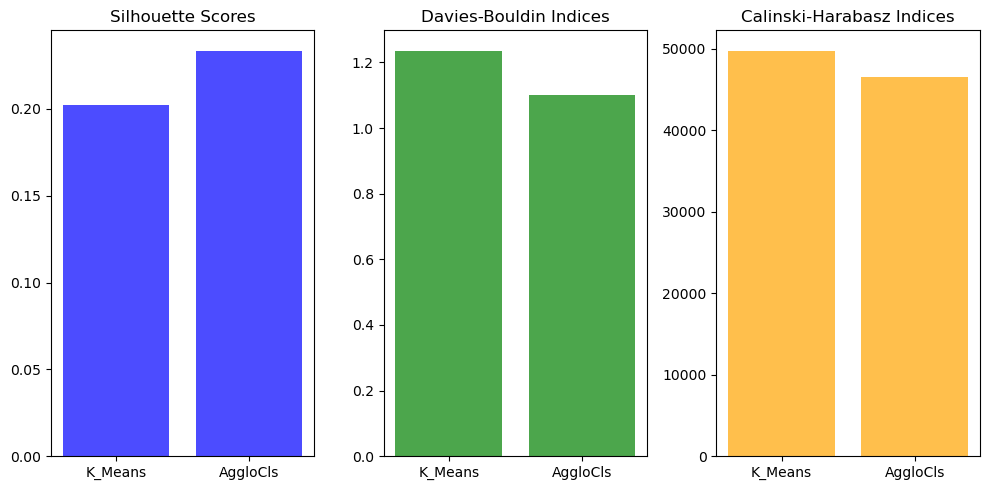

In [95]:
import matplotlib.pyplot as plt

# Silhouette Scores
silhouette_scores = [silhouette_score_km, silhouette_score_ac]

# Davies-Bouldin Indices
davies_bouldin_indices = [davies_score_km, davies_score_ac]

# Calinski-Harabasz Indices
calinski_harabasz_indices = [calinski_score_km, calinski_score_ac]

# Cluster labels
clusters = ['K_Means', 'AggloCls']

# Plotting the Silhouette Scores
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.bar(clusters, silhouette_scores, color='blue', alpha=0.7)
plt.title('Silhouette Scores')

# Plotting the Davies-Bouldin Indices
plt.subplot(1, 3, 2)
plt.bar(clusters, davies_bouldin_indices, color='green', alpha=0.7)
plt.title('Davies-Bouldin Indices')

# Plotting the Calinski-Harabasz Indices
plt.subplot(1, 3, 3)
plt.bar(clusters, calinski_harabasz_indices, color='orange', alpha=0.7)
plt.title('Calinski-Harabasz Indices')

plt.tight_layout()
plt.show()


Based on the above metrics we can conclude the below points. Clusters formed with `Agglometric clustering` model has better Silhouette Score than K means clusters. It indicates that clusters formed with Agglometric model is better at matching a given object to its own cluster than its neighboring ones.

Based on the above metrics we can conclude the below points. 
1. Clusters formed with Agglometric clustering model has better Silhouette Score than K means clusters. It indicates that clusters formed with Agglometric model is better at matching a given object to its own cluster than its neighboring ones.
2. According to the Davies-Bouldin Index got for both techniques, K means clusters got value of 0.7 which is lesser than 0.8 got with Agglometric clustering. This indicates that K means clustering is performing better according to this index.
3. The higher index of Calinski-Harabasz with k means clustering(50k) indicates that clusters formed with this technique is better than agglometric clustering.

Comparatively metrics we got from both methods don’t have much difference but we can say that K means has performed little better than Agglometric clustering for our dataset.

#### So we decided to stick with `Agglometric Clusters`

### Rating each cluster on Agglometric Clusters
To rate the clusters we have grouped the whole data according to the `AgglomerativeClustering` and then found the average `Price_Per_Min_OnAir` of each cluster and then the cluster with least average is given `Rating 5` and the highest is given `Rating 1`

In [96]:
df['average_ratings'] = df.groupby('Agg_Clusters')['Price_Per_Min_OnAir'].transform('mean')
df['Rating'] = df['average_ratings'].rank(ascending=False, method='min')
df['Rating'] = df['Rating'].map({rank: i+1 for i, rank in enumerate(sorted(df['Rating'].unique(), reverse=False))})

In [97]:
df['Price_Per_Min_OnAir'].groupby(df["Rating"]).describe()

,count,mean,std,min,25%,50%,75%,max
Rating,,,,,,,,
1,278.0,79.212694,19.660205,61.239726,66.466790,69.186603,91.419598,152.396804
2,648.0,43.935604,6.694235,34.240602,38.452863,42.004703,48.855551,62.474667
3,4475.0,21.061611,5.265059,12.677346,16.394547,19.839024,25.157895,36.860177
4,7948.0,9.213419,2.265085,4.153425,7.308108,8.911082,11.145105,16.184371
5,45932.0,4.874265,1.607592,0.862626,3.776423,4.767922,5.973554,11.901042


Ploting a scatter plot on the final ratings on the axis of `Duration` and `Price_Per_Min_OnAir`

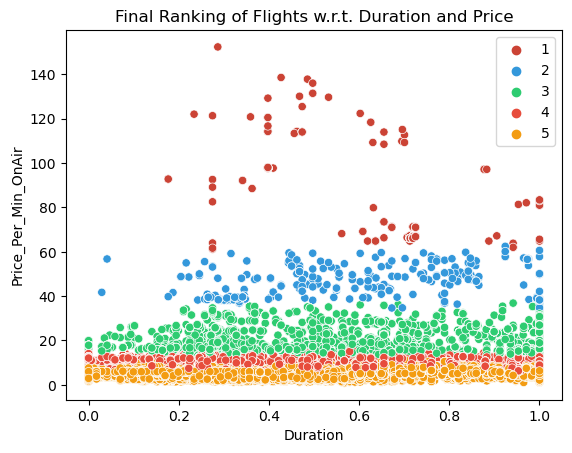

In [98]:
pl = sns.scatterplot(data = df,x=df["Duration"], y=df["Price_Per_Min_OnAir"],hue=df["Rating"], palette= color_pallet)
pl.set_title("Final Ranking of Flights w.r.t. Duration and Price")
plt.legend()
plt.show()

# Conclusion

The clustering technique implemented can segment the data into proper use groups from which certain characteristics can be used to arrive at the required solution in this case of achieving the best deal on airline from point A to point B. Factors such as fare, luggage count and duration are considered in this case to determine a cluster that meets all the minimal requirements of the above.
Future improvisation of the above analysis could be that a suggestive mechanism could be implemented given the requirements to advise best carrier.